<a href="https://colab.research.google.com/github/PaulGru/ilm/blob/main/ilm_expe3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/PaulGru/ilm.git


Cloning into 'ilm'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 31 (delta 18), reused 23 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 20.61 KiB | 10.31 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [4]:
%cd /content/ilm


/content/ilm


In [5]:
!pip install -r requirements.txt
!pip install datasets transformers torch torchvision


Ignoring importlib-metadata: markers 'python_version < "3.10"' don't match your environment
  Using cached datasets-3.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-ma

In [6]:
from datasets import load_dataset

# Chargement du dataset 20 Newsgroups
train_dataset = load_dataset("SetFit/20_newsgroups", split="train")

# Vérifie rapidement les colonnes et un exemple
print(train_dataset.column_names)
print(train_dataset[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/734 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/8.91M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11314 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7532 [00:00<?, ? examples/s]

['text', 'label', 'label_text']
{'text': 'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.', 'label': 7, 'label_text': 'rec.autos'}


In [7]:
import random
import os

test_dataset = load_dataset("SetFit/20_newsgroups", split="test")

categories = list(set(train_dataset["label_text"]))
print("Catégories uniques :", categories)

random.shuffle(categories)
num_train_cats = int(0.6 * len(categories))  # par exemple, 60% pour l'entraînement (InD)
train_categories = categories[:num_train_cats]
ood_categories = categories[num_train_cats:]
print("Catégories d'entraînement (InD) :", train_categories)
print("Catégories OoD :", ood_categories)

# Pour chaque catégorie InD, créer un fichier de training
train_folder = "20news_env"
os.makedirs(train_folder, exist_ok=True)

def write_dataset_to_file(dataset, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for example in dataset:
            f.write(example["text"].replace("\n", " ") + "\n")

# Pour iLM, créez un fichier par environnement (catégorie)
for cat in train_categories:
    subset = train_dataset.filter(lambda x: x["label_text"] == cat)
    write_dataset_to_file(subset, os.path.join(train_folder, f"{cat}.txt"))
    print(f"Fichier pour {cat} créé avec {len(subset)} exemples.")

#on prend 20% du train pour InD
ind_val = train_dataset.filter(lambda x: x["label_text"] in train_categories).train_test_split(test_size=0.2, seed=42)["test"]
write_dataset_to_file(ind_val, os.path.join(train_folder, "val_ind.txt"))
print("Fichier de validation InD créé.")

# on filtre
ood_val = test_dataset.filter(lambda x: x["label_text"] in ood_categories)
# Peut prendre un sous ensemble
write_dataset_to_file(ood_val, os.path.join(train_folder, "val_ood.txt"))
print("Fichier de validation OoD créé.")


Repo card metadata block was not found. Setting CardData to empty.


Catégories uniques : ['soc.religion.christian', 'comp.windows.x', 'talk.politics.mideast', 'talk.politics.guns', 'sci.space', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.motorcycles', 'comp.graphics', 'sci.med', 'comp.sys.ibm.pc.hardware', 'rec.sport.baseball', 'talk.religion.misc', 'rec.sport.hockey', 'rec.autos', 'misc.forsale', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'sci.crypt', 'sci.electronics']
Catégories d'entraînement (InD) : ['sci.crypt', 'rec.sport.hockey', 'sci.med', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'rec.autos', 'talk.religion.misc', 'rec.sport.baseball', 'soc.religion.christian', 'talk.politics.misc', 'alt.atheism', 'sci.space']
Catégories OoD : ['comp.sys.mac.hardware', 'comp.windows.x', 'talk.politics.guns', 'sci.electronics', 'rec.motorcycles', 'misc.forsale', 'talk.politics.mideast', 'comp.graphics']


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour sci.crypt créé avec 595 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour rec.sport.hockey créé avec 600 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour sci.med créé avec 594 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour comp.os.ms-windows.misc créé avec 591 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour comp.sys.ibm.pc.hardware créé avec 590 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour rec.autos créé avec 594 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour talk.religion.misc créé avec 377 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour rec.sport.baseball créé avec 597 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour soc.religion.christian créé avec 599 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour talk.politics.misc créé avec 465 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour alt.atheism créé avec 480 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier pour sci.space créé avec 593 exemples.


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier de validation InD créé.


Filter:   0%|          | 0/7532 [00:00<?, ? examples/s]

Fichier de validation OoD créé.


In [10]:
!python run_invariant_mlm.py \
  --model_name_or_path roberta-base \
  --train_file 20news_env \
  --validation_file 20news_env/val_ind.txt \
  --do_train --do_eval \
  --nb_steps 2500 \
  --learning_rate 1e-5 \
  --output_dir output/20news_iLM_InD \
  --seed 42 \
  --per_device_train_batch_size 2 \
  --gradient_accumulation_steps 8 \
  --ensembling True \
  --overwrite_cache \
  --overwrite_output_dir \
  --nb_steps_heads_saving 500


2025-03-26 18:03:01.269482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743012181.333585   18985 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743012181.352429   18985 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 18:03:01.427233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
03/26/2025 18:03:08 - INFO - __main__ -   Process rank: -1, device: cpu, n_gpu: 0distributed training: False, 16-bits trainin

Chaque environnement (catégorie de sujet) a sa propre tête de prédiction dans iLM ou ensLM. Chacune apprend à prédire les tokens, mais à partir d'une distribution de données différente.

Il peut donc de produire :
- des divergences, les têtes apprenent des choses différentes.
- des convergences, les têtes deviennent similaires entre elles, c'est ce que l'on souhaite car si l'encoder encode des représentations invariantes, alors toutes les têtes ont besoind d'apprendre la même chose.

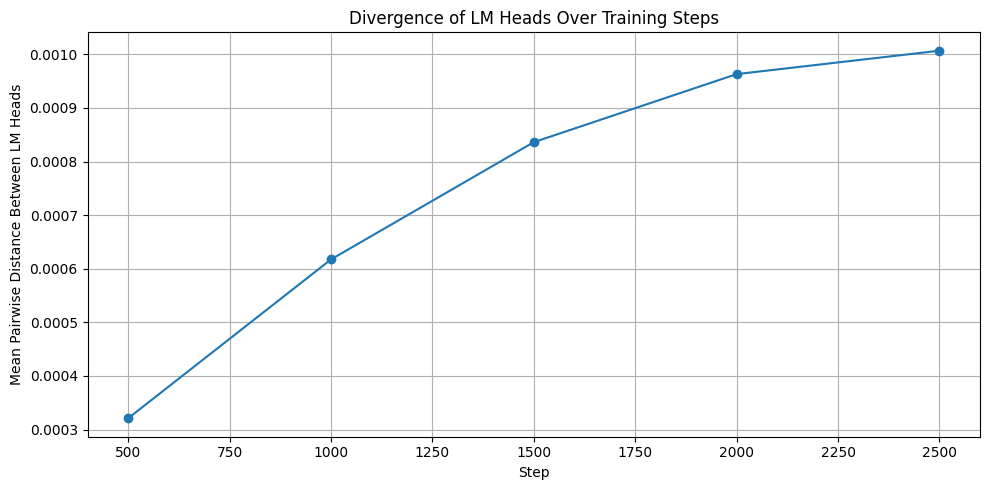

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Dossier contenant les fichiers .npy sauvegardés à chaque step
heads_dir = "lm_heads"

# Récupérer tous les fichiers, triés par step
files = sorted([f for f in os.listdir(heads_dir) if f.endswith(".npy")])

# Parser les steps
steps = sorted(list(set(int(f.split("-")[-1].replace(".npy", "")) for f in files)))

# Récupérer les environnements
envs = sorted(list(set(f.split("-")[0] for f in files)))

# Dictionnaire {step: {env: head_vector}}
all_heads = {step: {} for step in steps}

for f in files:
    env, step = f.split("-")
    step = int(step.replace(".npy", ""))
    vec = np.load(os.path.join(heads_dir, f))
    all_heads[step][env] = vec.flatten()

# Maintenant, on trace la distance moyenne entre toutes les paires de têtes à chaque step
mean_distances = []

for step in steps:
    heads = all_heads[step]
    env_vectors = list(heads.values())
    n = len(env_vectors)
    distances = []
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(env_vectors[i] - env_vectors[j])
            distances.append(dist)
    mean_distances.append(np.mean(distances))

# Tracer la courbe
plt.figure(figsize=(10, 5))
plt.plot(steps, mean_distances, marker='o')
plt.xlabel("Step")
plt.ylabel("Mean Pairwise Distance Between LM Heads")
plt.title("Divergence of LM Heads Over Training Steps")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!python run_invariant_mlm.py \
  --model_name_or_path distilbert-base-uncased \
  --train_file 20news_env \
  --validation_file 20news_env/val_ind.txt \
  --do_train --do_eval \
  --nb_steps 2500 \
  --learning_rate 1e-5 \
  --output_dir output/20news_iLM_InD \
  --seed 42 \
  --per_device_train_batch_size 2 \
  --gradient_accumulation_steps 8 \
  --ensembling True \
  --overwrite_cache \
  --overwrite_output_dir \
  --nb_steps_heads_saving 500


2025-03-25 15:00:13.477374: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 15:00:13.496517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742914813.518579    9351 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742914813.525286    9351 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 15:00:13.547838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

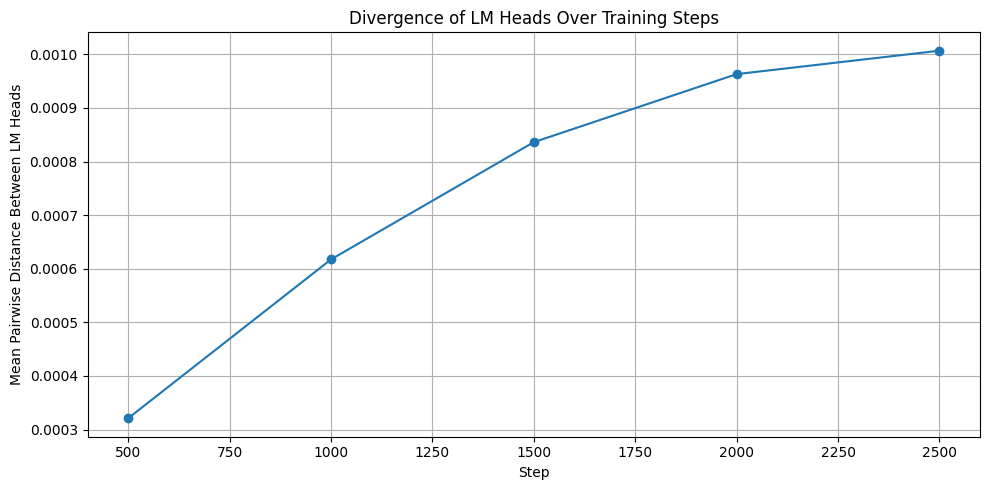

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Dossier contenant les fichiers .npy sauvegardés à chaque step
heads_dir = "lm_heads"

# Récupérer tous les fichiers, triés par step
files = sorted([f for f in os.listdir(heads_dir) if f.endswith(".npy")])

# Parser les steps
steps = sorted(list(set(int(f.split("-")[-1].replace(".npy", "")) for f in files)))

# Récupérer les environnements
envs = sorted(list(set(f.split("-")[0] for f in files)))

# Dictionnaire {step: {env: head_vector}}
all_heads = {step: {} for step in steps}

for f in files:
    env, step = f.split("-")
    step = int(step.replace(".npy", ""))
    vec = np.load(os.path.join(heads_dir, f))
    all_heads[step][env] = vec.flatten()

# Maintenant, on trace la distance moyenne entre toutes les paires de têtes à chaque step
mean_distances = []

for step in steps:
    heads = all_heads[step]
    env_vectors = list(heads.values())
    n = len(env_vectors)
    distances = []
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(env_vectors[i] - env_vectors[j])
            distances.append(dist)
    mean_distances.append(np.mean(distances))

# Tracer la courbe
plt.figure(figsize=(10, 5))
plt.plot(steps, mean_distances, marker='o')
plt.xlabel("Step")
plt.ylabel("Mean Pairwise Distance Between LM Heads")
plt.title("Divergence of LM Heads Over Training Steps")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!python run_invariant_mlm.py \
  --model_name_or_path distilbert-base-uncased \
  --train_file 20news_env \
  --validation_file 20news_env/val_ood.txt \
  --do_eval \
  --output_dir output/20news_iLM_OoD \
  --seed 42 \
  --per_device_train_batch_size 2 \
  --gradient_accumulation_steps 8 \
  --ensembling True \
  --overwrite_cache


2025-03-24 08:07:21.958294: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 08:07:21.976312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742803641.997925   28686 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742803642.004544   28686 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 08:07:22.026455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
!python run_invariant_mlm.py \
  --model_name_or_path distilbert-base-uncased \
  --train_file 20news_env \
  --validation_file 20news_env/val_ind.txt \
  --do_train --do_eval \
  --nb_steps 2500 \
  --learning_rate 1e-5 \
  --output_dir output/20news_iLM_InD \
  --seed 42 \
  --per_device_train_batch_size 2 \
  --gradient_accumulation_steps 8 \
  --ensembling False \
  --overwrite_output_dir \
  --overwrite_cache \
  --nb_steps_heads_saving 500


2025-03-25 15:19:16.158578: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 15:19:16.176892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742915956.198645   14385 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742915956.205307   14385 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 15:19:16.227428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

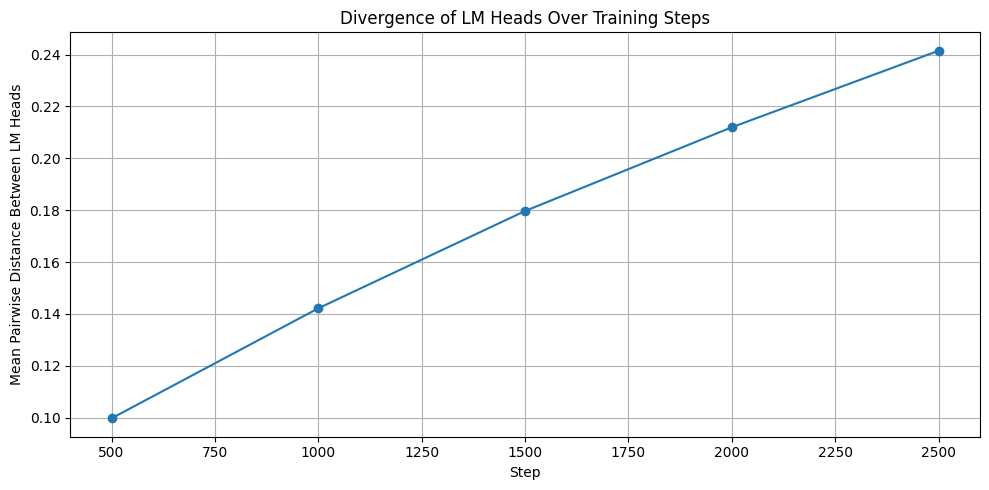

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Dossier contenant les fichiers .npy sauvegardés à chaque step
heads_dir = "lm_heads"

# Récupérer tous les fichiers, triés par step
files = sorted([f for f in os.listdir(heads_dir) if f.endswith(".npy")])

# Parser les steps
steps = sorted(list(set(int(f.split("-")[-1].replace(".npy", "")) for f in files)))

# Récupérer les environnements
envs = sorted(list(set(f.split("-")[0] for f in files)))

# Dictionnaire {step: {env: head_vector}}
all_heads = {step: {} for step in steps}

for f in files:
    env, step = f.split("-")
    step = int(step.replace(".npy", ""))
    vec = np.load(os.path.join(heads_dir, f))
    all_heads[step][env] = vec.flatten()

# Maintenant, on trace la distance moyenne entre toutes les paires de têtes à chaque step
mean_distances = []

for step in steps:
    heads = all_heads[step]
    env_vectors = list(heads.values())
    n = len(env_vectors)
    distances = []
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(env_vectors[i] - env_vectors[j])
            distances.append(dist)
    mean_distances.append(np.mean(distances))

# Tracer la courbe
plt.figure(figsize=(10, 5))
plt.plot(steps, mean_distances, marker='o')
plt.xlabel("Step")
plt.ylabel("Mean Pairwise Distance Between LM Heads")
plt.title("Divergence of LM Heads Over Training Steps")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.animation import FuncAnimation

# === Paramètres ===
lm_heads_dir = "/content/ilm/lm_heads"  # Change ce chemin si besoin
output_gif_path = "lm_heads_pca_animation.gif"

# === Étape 1 : Chargement des fichiers ===
files = sorted(os.listdir(lm_heads_dir))
steps = sorted(list(set(int(f.split("-")[-1].replace(".npy", "")) for f in files)))
envs = sorted(list(set(f.split("-")[0] for f in files)))

step_to_weights = {}
for step in steps:
    head_weights = []
    for env in envs:
        fname = f"{env}-{step}.npy"
        fpath = os.path.join(lm_heads_dir, fname)
        if os.path.exists(fpath):
            weights = np.load(fpath)
            head_weights.append(weights.flatten())  # Aplatir les poids pour PCA
    if head_weights:
        step_to_weights[step] = np.stack(head_weights)

# === Étape 2 : PCA global ===
all_weights = np.concatenate(list(step_to_weights.values()), axis=0)
pca = PCA(n_components=2)
pca.fit(all_weights)
projected_steps = {step: pca.transform(w) for step, w in step_to_weights.items()}

# === Étape 3 : Animation ===
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter([], [], c='blue')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_title("PCA of LM Heads over Training Steps")
text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

def update(frame):
    step = steps[frame]
    data = projected_steps[step]
    sc.set_offsets(data)
    text.set_text(f"Step: {step}")
    return sc, text

ani = FuncAnimation(fig, update, frames=len(steps), interval=800, blit=True)
plt.close()  # Pour ne pas afficher le plot statique

# === Étape 4 : Sauvegarde ===
ani.save(output_gif_path, writer='pillow')
print(f"Animation enregistrée ici : {output_gif_path}")


Animation enregistrée ici : lm_heads_pca_animation.gif


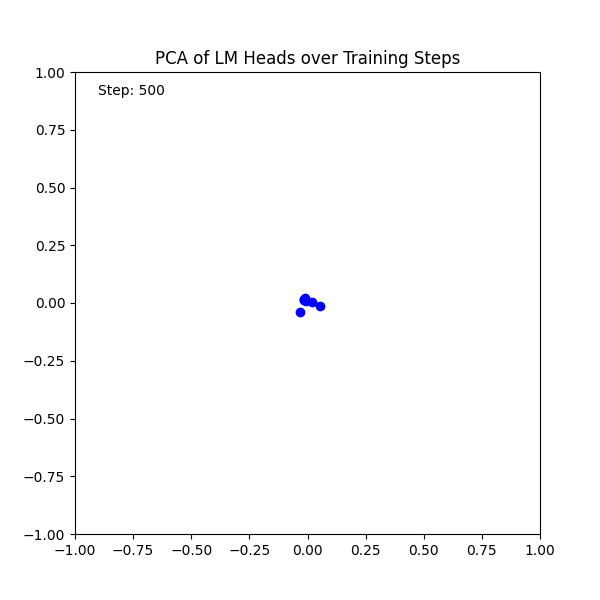

In [ ]:
from IPython.display import Image
Image(output_gif_path)


In [ ]:
!python run_invariant_mlm.py \
  --model_name_or_path distilbert-base-uncased \
  --train_file 20news_env \
  --validation_file 20news_env/val_ood.txt \
  --do_eval \
  --output_dir output/20news_iLM_OoD \
  --seed 42 \
  --per_device_train_batch_size 2 \
  --gradient_accumulation_steps 8 \
  --ensembling False \
  --overwrite_output_dir \
  --overwrite_cache


2025-03-24 08:21:21.477733: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 08:21:21.496422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742804481.518948   32462 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742804481.525771   32462 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 08:21:21.548342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
import random
import os
from datasets import load_dataset

# Charger les splits train et test
train_dataset = load_dataset("SetFit/20_newsgroups", split="train")
test_dataset = load_dataset("SetFit/20_newsgroups", split="test")

# Récupérer la liste complète des catégories (les 20 newsgroups)
categories = list(set(train_dataset["label_text"]))
print("Catégories uniques :", categories)

# Diviser aléatoirement les catégories en deux groupes : InD et OoD
random.shuffle(categories)
num_train_cats = int(0.6 * len(categories))  # par exemple, 60% pour l'entraînement (InD)
train_categories = categories[:num_train_cats]
ood_categories = categories[num_train_cats:]
print("Catégories d'entraînement (InD) :", train_categories)
print("Catégories OoD :", ood_categories)

# Créer un dossier pour stocker les fichiers
output_dir = "20news_env"
os.makedirs(output_dir, exist_ok=True)

def write_dataset_to_file(dataset, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for example in dataset:
            f.write(example["text"].replace("\n", " ") + "\n")

# 1. Pour eLM : Fusionner tous les exemples InD dans un seul fichier d'entraînement
inD_train = train_dataset.filter(lambda x: x["label_text"] in train_categories)
train_file_path = os.path.join(output_dir, "train.txt")
write_dataset_to_file(inD_train, train_file_path)
print(f"Fichier d'entraînement eLM créé avec {len(inD_train)} exemples :", train_file_path)

# 2. Créer le fichier de validation InD : prendre 20% des exemples InD à partir du train
split_train = inD_train.train_test_split(test_size=0.2, seed=42)
val_ind = split_train["test"]
val_ind_path = os.path.join(output_dir, "val_ind.txt")
write_dataset_to_file(val_ind, val_ind_path)
print(f"Fichier de validation InD créé avec {len(val_ind)} exemples :", val_ind_path)

# 3. Créer le fichier de validation OoD : filtrer le split test sur les catégories OoD
val_ood = test_dataset.filter(lambda x: x["label_text"] in ood_categories)
val_ood_path = os.path.join(output_dir, "val_ood.txt")
write_dataset_to_file(val_ood, val_ood_path)
print(f"Fichier de validation OoD créé avec {len(val_ood)} exemples :", val_ood_path)


Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


Catégories uniques : ['talk.politics.mideast', 'comp.os.ms-windows.misc', 'talk.politics.misc', 'comp.sys.ibm.pc.hardware', 'comp.windows.x', 'sci.space', 'sci.crypt', 'misc.forsale', 'comp.graphics', 'rec.sport.baseball', 'soc.religion.christian', 'rec.motorcycles', 'talk.religion.misc', 'sci.med', 'talk.politics.guns', 'alt.atheism', 'rec.sport.hockey', 'sci.electronics', 'comp.sys.mac.hardware', 'rec.autos']
Catégories d'entraînement (InD) : ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'talk.politics.mideast', 'rec.motorcycles', 'alt.atheism', 'talk.politics.misc', 'sci.electronics', 'comp.os.ms-windows.misc', 'comp.windows.x', 'talk.politics.guns', 'rec.autos', 'comp.graphics']
Catégories OoD : ['rec.sport.hockey', 'sci.space', 'sci.med', 'talk.religion.misc', 'misc.forsale', 'soc.religion.christian', 'rec.sport.baseball', 'sci.crypt']


Filter:   0%|          | 0/11314 [00:00<?, ? examples/s]

Fichier d'entraînement eLM créé avec 6774 exemples : 20news_env/train.txt
Fichier de validation InD créé avec 1355 exemples : 20news_env/val_ind.txt


Filter:   0%|          | 0/7532 [00:00<?, ? examples/s]

Fichier de validation OoD créé avec 3021 exemples : 20news_env/val_ood.txt


In [ ]:
!python run_invariant_mlm.py \
  --model_name_or_path distilbert-base-uncased \
  --train_file 20news_env \
  --validation_file 20news_env/val_ind.txt \
  --do_train --do_eval \
  --nb_steps 2500 \
  --learning_rate 1e-5 \
  --output_dir output/20news_eLM_InD \
  --seed 42 \
  --per_device_train_batch_size 2 \
  --gradient_accumulation_steps 8 \
  --overwrite_output_dir \
  --overwrite_cache


2025-03-24 08:35:48.453319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 08:35:48.472076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742805348.494604   36159 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742805348.501425   36159 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 08:35:48.524520: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
!python run_invariant_mlm.py \
  --model_name_or_path distilbert-base-uncased \
  --train_file 20news_env \
  --validation_file 20news_env/val_ood.txt \
  --do_eval \
  --output_dir output/20news_eLM_OoD \
  --seed 42 \
  --per_device_train_batch_size 2 \
  --gradient_accumulation_steps 8 \
  --overwrite_output_dir \
  --overwrite_cache


2025-03-24 08:42:45.519711: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 08:42:45.538214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742805765.560255   38056 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742805765.567002   38056 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 08:42:45.589780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from tqdm import tqdm

# Charger uniquement le split d'entraînement
dataset = load_dataset("SetFit/20_newsgroups", split="train")

# Charger le tokenizer associé à distilbert-base-uncased
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Calculer le nombre total de tokens dans le split train
total_tokens = 0
for example in tqdm(dataset, desc="Tokenizing"):
    tokens = tokenizer(example["text"], truncation=False, add_special_tokens=False)["input_ids"]
    total_tokens += len(tokens)

print(f"\nTotal number of tokens in the training set: {total_tokens}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/734 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/8.91M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11314 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7532 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing: 100%|██████████| 11314/11314 [00:11<00:00, 999.63it/s] 


Total number of tokens in the training set: 3978979
